**Project:** Sentiment Analysis of [Amazon Product Reviews](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews)

**Author:** [Giuseppe Muschetta](https://github.com/peppe212)

**Python version:** 3.8

# CLASSIFICATION WITH DistilBERT

<h2 style="margin-bottom: 0;">1. Size and Speed</h2>
<p style="margin-top: 0;">DistilBERT is approximately 40% smaller and 60% faster than BERT. This is achieved by reducing the number of Transformer layers. DistilBERT has 6 Transformer layers, unlike the 12 of BERT Base. Since it has fewer parameters (about 66 million compared to BERT Base's 110 million), DistilBERT is easier to run on hardware with limited resources and requires less memory during training and inference.</p>

<h2 style="margin-bottom: 0;">2. Performance</h2>
<p style="margin-top: 0;">DistilBERT manages to maintain about 97% of BERT's capabilities on language understanding tasks despite having only about 60% of the parameters. This is achieved through a process of 'knowledge distillation', which involves training DistilBERT to mimic the behaviour of the larger BERT model. Although the performance is slightly lower than that of BERT, the difference is often an acceptable trade-off considering the benefits in terms of computational efficiency and cost.</p>

<h2 style="margin-bottom: 0;">3. Applications and Usage</h2>
<p style="margin-top: 0;">DistilBERT can be used in almost any context in which BERT is used, especially when computing resources are a limitation or when higher processing speed is required, such as in applications on mobile devices or in latency sensitive environments. BERT is preferable for applications that require maximum precision and where computational resources are not a major constraint, such as in research environments or when working with very complex language problems.</p>

In [1]:
# Sopprimiamo i fastidiosissimi warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importiamo tutte le librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import torch
from torch.utils.data import (DataLoader, 
                              RandomSampler, 
                              SequentialSampler,
                              TensorDataset)

from transformers import (DistilBertTokenizer, 
                          DistilBertForSequenceClassification, 
                          AdamW, 
                          get_scheduler)

from sklearn.model_selection import train_test_split

from sklearn.metrics import (roc_curve, 
                             auc, 
                             confusion_matrix,
                             precision_recall_curve,
                             accuracy_score, 
                             classification_report)

### IMPOSTAZIONE DEI PATH

In [3]:
# Caricamento del Dataset raw, il DistilBERT vuole il testo grezzo
DATASET_PATH = Path() / "Dataset/balanced_reviews.csv"
df = pd.read_csv(DATASET_PATH)
if df.isna().any().any():
    df.fillna("", inplace=True)

# Impostazione path per il salvataggio immagini
IMAGES_PATH = Path() / "Images" / "DistilBERT"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_my_image(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return


# Gestione salvataggio e caricamento del modello di LinearSVC
MODEL_PATH = Path() / "Saved_models" / "DistilBERT"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Salva il modello su un file di estensione default.tf
def save_my_model(model, model_name='DistilBERT', model_extension="pth"):
    path = MODEL_PATH / f"{model_name}.{model_extension}"
    try:
        # salva il modello utilizzando la libreria pytorch
        torch.save(model.state_dict(), path)
        print(f"Modello salvato correttamente in: {path}")
    except Exception as e:
        print(f"Si è verificato un errore durante il salvataggio del modello: {e}")
        raise FileNotFoundError
#end_function

# Carica il modello dal file con estensione a default.tf
def load_my_model(model_name="DistilBERT", model_extension="pth", device_type="mps"):
    path = MODEL_PATH / f"{model_name}.{model_extension}"
    if path.exists():
        try:
            # Impostazione del device, uso la mia GPU
            device = torch.device(device_type)
            # Creazione dell'istanza del modello con due classi
            model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
            # Caricamento dello state dict e del device primario, a default la GPU
            model.load_state_dict(torch.load(path, map_location=device))
            # Impostiamo il modello in fase valutazione
            model.eval()
            model.to(device)
            print(f"Modello caricato correttamente da: {path}")
            return model, device
        except Exception as e:
            print(f"Si è verificato un errore durante il caricamento del modello: {e}")
            raise
    else:
        error_msg = f"Il file del modello non esiste: {path}"
        print(error_msg)
        raise FileNotFoundError(error_msg)
#end_function



### PREPARAZIONE DEI DATI

In [4]:
# È necessario eseguire questa cella anche se si intende caricare il modello da file
# Funzione per convertire i dati in formato compatibile con DistilBERT
def encode_data(tokenizer, texts, max_len):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)
# end_function 'encode_data(_,_,_)

# Caricamento del Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Preparazione dei dati
texts = df['Text'].values
labels = df['sentiment'].values

# Dividere i dati in training e validation (usa un sottoinsieme per velocizzare)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# Encoding dei dati
train_inputs, train_masks = encode_data(tokenizer, train_texts, max_len=64)
val_inputs, val_masks = encode_data(tokenizer, val_texts, max_len=64)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

# Creazione del DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,
                              sampler=train_sampler,
                              batch_size=32,
                              # di vitale importanza impostare il massimo #core della macchina senza però
                              # eccedere il loro totale, si creerebbe un overhead inutile che potrebbe
                              # addirittura degradare le performance
                              num_workers=11) # ho messo il numero di core della mia specifica macchina

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data,
                            sampler=val_sampler,
                            batch_size=32,
                            # anche qui imposto il max num di core del mio mac con M1 Pro
                            num_workers=11) # stessa cosa, ho impostato il max num di core della mia macchina

### TRAINING DEL MODELLO DistilBERT

In [5]:
# QUI ANDIAMO A TRAINARE E VALUTARE IL MODELLO DistilBERT
# Se il modello è già salvato su file, questa cella potrebbe non essere eseguita
# Si può procedere direttamente alla cella idi caricamento del file

# CREO E CONFIGURO IL MODELLO:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
# Ottimizzatore
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
# IMPORTANTE: lasciando tutto il codice inalterato, se settiamo il numero di epoche > 3
# abbiamo una accuracy che raggiunge e supera il 94%
epochs = 1
total_steps = len(train_dataloader) * epochs
# Scheduler
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)
# IMPOSTIAMO LA GPU PER TUTTI I CALCOLI PIU' IMPEGNATIVI 
# E NON LA CPU (che è infinitamente più lenta)
# Imposto la GPU come device principale. 
# Utilizzo l'API Grafica Apple Metal
device = torch.device('mps')
model.to(device)

# Funzione per addestrare il modello
def train_model(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for step, batch in enumerate(dataloader):
        batch = [r.to(device) for r in batch]
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(dataloader)
    return avg_train_loss


# ESECUZIONE DEL TRAINING E DELLA VALUTAZIONE:
train_loss = train_model(model, train_dataloader, optimizer, scheduler, device)
print(f'Train loss: {train_loss}')

# per mancanza di tempo dato che dovevo per forza rieseguire il codice 
# ho ri-trainato impostando soltanto un epoca per risparmiare tempo, 
# se avessi trainato anche con 5 epoche come ho fatto all'inzio
# avrei anche raggiunto e, forse, superato il 94% 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train loss: 0.2237687966537034


#### SALVATAGGIO MODELLO

In [ ]:
# Salvo il modello
save_my_model(model)

#### CARICO IL MODELLO   

In [5]:
# CARICAMENTO DEL MODELLO:
model, device = load_my_model()

# la funzione di caricamento l'ho scritta apposta per tenere conto:
# 1 - del device principale
# 2 - dell'assegnazione della GPU ad esso
# 3 - del settaggio del modello già in modalità model.eval() 
#     in modo che sia già pronto a predire

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modello caricato correttamente da: Saved_models/DistilBERT/DistilBERT.pth


### VALUTAZIONE DEL MODELLO DistilBERT

In [6]:
# Funzione per valutare il modello
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    for batch in dataloader:
        batch = [t.to(device) for t in batch]
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    return accuracy, report

# Funzione di predizione su dataset
def predict_on_dataset(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []
    with torch.no_grad():
        for batch in dataloader:
            batch = [t.to(device) for t in batch]
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs[:,1].cpu().numpy())
            true_labels.extend(b_labels.cpu().numpy())
    return np.array(predictions), np.array(true_labels), np.array(probabilities)

accuracy, report = evaluate_model(model, val_dataloader, device)
print(f"Accuracy: {accuracy}\nClassification Report:\n{report}")
predictions, true_labels, probabilities = predict_on_dataset(model, val_dataloader)
print("Predictions completed.")
# Matrice di confusione testuale
conf_matrix = confusion_matrix(true_labels, predictions)
print(conf_matrix)

Accuracy: 0.9292578125
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     12812
           1       0.93      0.93      0.93     12788

    accuracy                           0.93     25600
   macro avg       0.93      0.93      0.93     25600
weighted avg       0.93      0.93      0.93     25600

Predictions completed.
[[11865   947]
 [  864 11924]]


### VISUALIZZAZIONE PERFORMANCE DEL MODELLO:

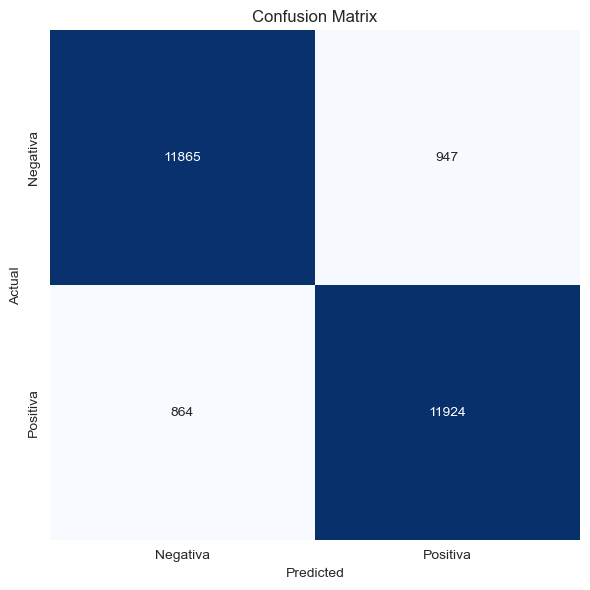

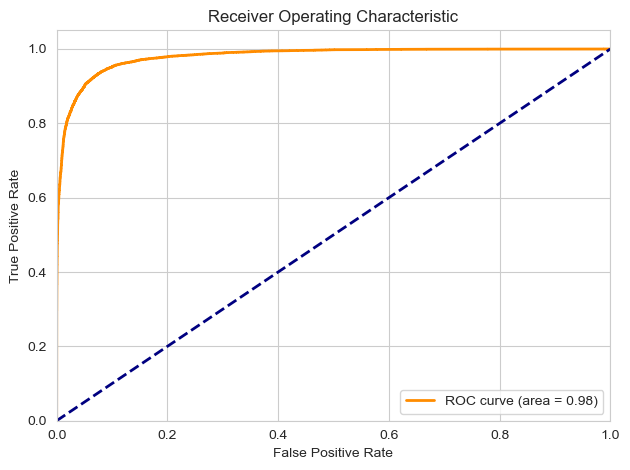

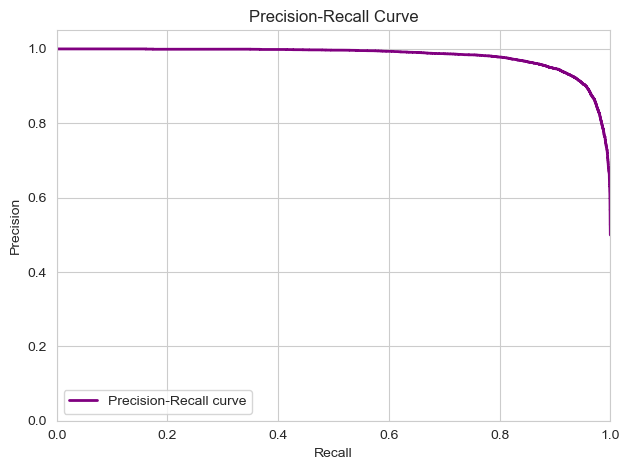

In [7]:
# Matrice di confusione
conf_matrix = confusion_matrix(true_labels, predictions)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=['Negativa', 'Positiva'],
            yticklabels=['Negativa', 'Positiva'],
            cmap="Blues", cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
save_my_image("confusione_matrix")
plt.show()

# Calcolo della Curva ROC
fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot della Curva ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
save_my_image("roc_curve")
plt.show()

# Calcolo della Curva Precision-Recall
precision, recall, _ = precision_recall_curve(true_labels, probabilities)

# Plot della Curva Precision-Recall
plt.figure()
plt.plot(recall, precision, color='purple', lw=lw,
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
save_my_image("precision_recall_curve")
plt.show()

### SIMULAZIONE APP DI PREDIZIONE RECENSIONI

In [7]:
# Utilizzo del modello caricato per fare predizioni
def predict_sentiment(text, tokenizer, model, device):
    # Tokenizza il testo
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=64,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    # Estrazione degli input IDs e le attention masks e sposta i tensori sul dispositivo appropriato
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    # Previsioni usando il modello
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Estrazione del logit del primo elemento del batch
    logits = outputs.logits

    # Usare softmax per ottenere le probabilità
    probs = torch.nn.functional.softmax(logits, dim=1)

    # Determinazione della classe predetta avente probabilità più alta
    prediction = torch.argmax(probs, dim=1).cpu().numpy()[0]

    return "Positiva" if prediction == 1 else "Negativa"


# Test della funzione di predizione di una recensione
# from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


# SCRIVI QUI UNA RECENSIONE IN INGLESE AFFINCHÉ IL MODELLO POSSA PREDIRE IL SUO SENTIMENT
review_text = "Excellent value I love the portability so I can take this on the run in my purse or backpack. Flavor is really good. My only disappointment was the actual size of each bar. Otherwise I thought it was really tasty and would love to buy again."


sentiment = predict_sentiment(review_text, tokenizer, model, device)
print(f"Il sentiment della recensione è stato predetto: {sentiment}")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


La recensione è predetta come: Positiva
